<span style="font-size:10pt">AI @ ENSPIMA_2022-2023_v1.0_Jean-Luc CHARLES (Jean-Luc.charles@ensam.eu)_CC BY-SA 4.0</span>

<div style="color:brown;font-family:arial;font-size:26pt;font-weight:bold;text-align:center"> 
Machine Learning $-$ MiniProject</div><br>
<hr>
<div style="color:blue;font-family:arial;font-size:22pt;font-weight:bold;text-align:center">
Training a neural network to diagnose bearing faults<br><br>
Part 3/3: The mini project.</div>
<hr>

Expected duration : 60 minutes

## Part-3 targeted learning objectives:

- Know how to train/operate a DNN to diagnose bearing faults using a labeled temporal dataset.
- The mini peoject: know how to train/operate a DNN to diagnose bearing faults using a labeled temporal dataset transformed in a spectral dataset.

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:12pt"> 
It is important to use a <span style="font-weight:bold;">Python Virtual Environment</span> (PVE) for your Python projects: a PVE makes it possible to control for each project the versions of the Python interpreter and the "sensitive" modules (like tensorflow).
    
All the notebooks must be loaded in a `jupyter notebook` or `jupyter lab` launched within the <b><span style="color: rgb(100, 151, 202);" >pyml-pm</span></b> PVE specially created for the session.    
</span></div>

In [1]:
import os, sys
# Delete the (numerous) warning messages from the **tensorflow** module:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# specific modules:
from utils.tools import scan_dir, plot_loss_accuracy

In [2]:
print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} incluant keras {keras.__version__}")
print(f"numpy     : {np.__version__}")

Python    : 3.8.18
tensorflow: 2.9.1 incluant keras 2.9.0
numpy     : 1.22.3


In [3]:
# set the seed of the random generators used by tensorflow:
SEED = 1234

Reminder: The bearing data set was obtained under the experimental conditions
- under normal condition (N)
- with outer race fault (OF)
- with inner race fault (IF)
- with roller fault (OF).

|class label|Fault type|Fault diameter|
|:---------:|:--------:|-------------:|
| 1         | N        | 0            |
| 2         | RF       | 0.18         |
| 3         | RF       | 0.36         |
| 4         | RF       | 0.54         |
| 5         | IF       | 0.36         |
| 6         | IF       | 0.36         |
| 7         | IF       | 0.54         |
| 8         | OF       | 0.18         |
| 9         | OF       | 0.36         |
| 10        | OF       | 0.54         |
 

# 4 $-$ A first try to train the neural network with the temporal dataset

## 4.1 $-$ Load the *CWRU* data and define some useful objects

In [4]:
npzfile = np.load('CWRU_dadaset.npz')
A, B, C = npzfile.values()
full_dataset = (A, B, C)

Let's have a look at the arrays shape:

In [5]:
A.shape, B.shape, C.shape

((10, 200, 1900), (10, 200, 1900), (10, 200, 1900))

As you can see, the dimensions of the arrays are : (#health_conditions, #samples, #data_points).

Let's define:
- `H` $\leadsto$ the number of health conditions
- `S` $\leadsto$ the number of samples per health contion
- `N` $\leadsto$ the number of data points per sample
- `L` $\leadsto$ the number of load cases.

In [6]:
H, S, N = A.shape           # we can use, A,B or C : they have the same shape
L = len(full_dataset)

print(f"L={L} load cases of the motor,")
print(f"H={H} health conditions,")
print(f"S={S} samples per health conditions,")
print(f"=> giving LxHxS={L*H*S} samples of N={N} data points per sample.")

L=3 load cases of the motor,
H=10 health conditions,
S=200 samples per health conditions,
=> giving LxHxS=6000 samples of N=1900 data points per sample.


Let's define the list of the labels for the health conditions:

In [7]:
# create the list of the health condition labels:
health_cond = ['N']
for def_type in 'RF', 'IF', 'OF':
    for size in '18', '36', '54':
        health_cond.append(f"{def_type}.{size}")
print(f"list of {len(health_cond)} health conditions:", health_cond)

list of 10 health conditions: ['N', 'RF.18', 'RF.36', 'RF.54', 'IF.18', 'IF.36', 'IF.54', 'OF.18', 'OF.36', 'OF.54']


## 4.2 $-$ Prepare the labeled dataset for the training

We have two actions to do:
- merge the 200 samples for each of the 10 health conditions and each of the 3 load cases into a single array of 200 $\times$ 10 $\times$ 3 = 6000 samples,
- build the array of the corresponding 6000 labels.

First we define the arrays with the right shapes:

In [8]:
x_full = np.ndarray((L*H*S, N), dtype='float')  # the array of the temporal samples
y_full = np.ndarray((L*H*S,), dtype='uint8')    # the array of the labels of the defects

Let's verify the shape of the arrays:

In [9]:
x_full.shape, y_full.shape

((6000, 1900), (6000,))

Then we fill `x_full` with samples and `y_full` with corresponding labels:

In [10]:
i = 0
for data in (A, B, C):       # browse the 3 load cases
    for h in range(H):       # browse the 10 health conditions (gives the label)
        for s in range(S):   # browse the 200 samples
            x_full[i] = data[h, s]
            y_full[i] = h    # the label is given by the health condition loop variable
            i += 1                                                  

To verify, let's plot the sample of rank 10 in `x_full`:

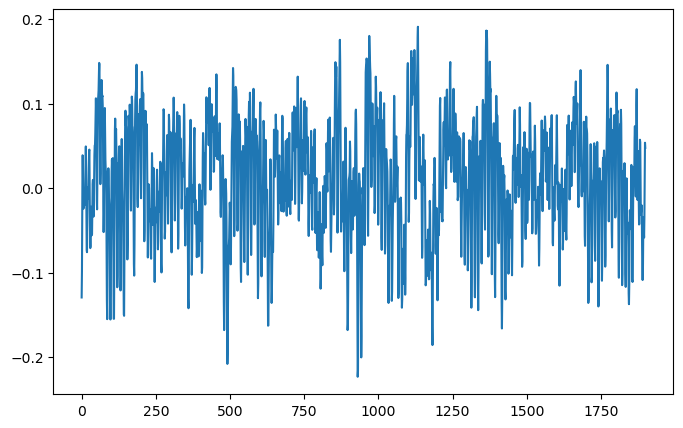

In [11]:
plt.figure(figsize=(8,5))
plt.plot(x_full[10]);

### Normalization of the temporal samples

We normalize the samples of `x_full` by dividing each one by the max of its absolute values.<br>
There are two ways to do this:

a/ Version with an **explicit loop** to browse through all the samples of `x_full`:

In [12]:
for i in range(len(x_full)):
    x_full[i] = x_full[i]/np.abs(x_full[i]).max()

Let's take a look now at the sample of rank 10 in `x_full`:

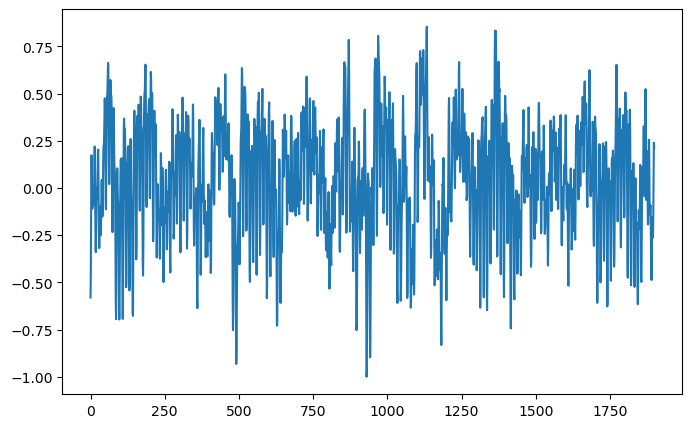

In [13]:
plt.figure(figsize=(8,5))
plt.plot(x_full[10]);

b/ the numpy **vectorized** style (more efficient):

In [14]:
x_full = x_full/np.abs(x_full).max(axis=1, keepdims=True)

Let's take a look now at the sample of rank 10 in `x_full`:

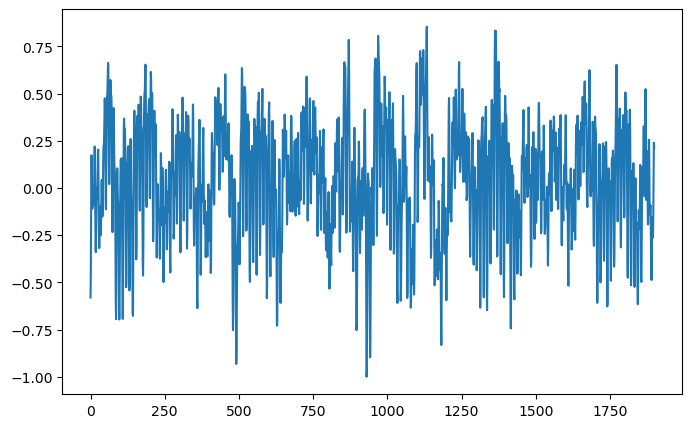

In [15]:
plt.figure(figsize=(8,5))
plt.plot(x_full[10]);

$\leadsto$ the values of `x_full` are now all in the range [-1, 1].

## 4.3 Split the full dataset into train and test datasets

Thanks to the `train_test_split` function of the `sklearn.model_selection` module we can split the `x_full` and `y_full` ndarrays into a _train_ dataset (for the training) and a _test_ dataset (for testing).<br>
Samples and labels are randomly selected but respecting the proportion of each of the 10 classes in the original dataset (this is the interest of the `stratify` argument of the `train_test_split` function):

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, lab_train, lab_test = train_test_split(x_full, y_full, 
                                                        stratify=y_full,      # use y_full to evenly distribute all classes 
                                                                              # in the train and test dadasets
                                                        test_size=0.33,        # 20 % test, 80% train 
                                                        random_state=SEED, 
                                                        shuffle=True)         # shuffe randomly the data

## 4.4 Transform labels to *one-hot* format

In [17]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' des labels :
y_train = to_categorical(lab_train)
y_test  = to_categorical(lab_test)

Just a recap of the shapes of the arrays:

In [18]:
x_train.shape, x_test.shape, lab_train.shape, lab_test.shape, y_train.shape, y_test.shape

((4020, 1900), (1980, 1900), (4020,), (1980,), (4020, 10), (1980, 10))

## 4.6 $-$ Build the Deep Neural Network

You will build a dense neural network witf this structure:
    
     Input layer : N inputs
     Hidden layer 'H1' : N neurones, activation fucntion: relu                                                    
     Hidden layer 'H2' : 600  neurones, activation fucntion: relu                          
     Hidden layer 'H3' : 200  neurones, activation fucntion: relu                         
     Hidden layer 'H4' : 100  neurones, activation fucntion: relu
     Output layer      : H   neurones, activation fucntion: softmax

In [19]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# set the seed of the random generators used by tensorflow:
SEED = 1234
tf.random.set_seed(SEED)

# the 5 lines to build the neural network:
model = Sequential()
model.add(Input(shape=(N,), name='Input'))
model.add(Dense(N, activation='relu', name='H1'))
model.add(Dense(600, activation='relu', name='H2'))
model.add(Dense(200, activation='relu', name='H3'))
model.add(Dense(100, activation='relu', name='H4'))
model.add(Dense(H, activation='softmax', name='Output'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 H1 (Dense)                  (None, 1900)              3611900   
                                                                 
 H2 (Dense)                  (None, 600)               1140600   
                                                                 
 H3 (Dense)                  (None, 200)               120200    
                                                                 
 H4 (Dense)                  (None, 100)               20100     
                                                                 
 Output (Dense)              (None, 10)                1010      
                                                                 
Total params: 4,893,810
Trainable params: 4,893,810
Non-trainable params: 0
_________________________________________________________________


Let's save the structure and the initial weights of the network if we want to rebuild later the network to its initial state:

In [21]:
import os

# Check wether the 'model' directory exist (create it if needed):
if not os.path.exists("models"): os.mkdir("models")

# define a uniq key:
key = 'CWRU_temporal_init'

# define the path where to store the network data:
path = os.path.join('models', key)

# savue the structure and the weights of the current neural network:
model.save(path)

# display the tree beginning at f'./models/{key}':
tree = scan_dir(f"./models/{key}")
print(f'\nFiles written:\n{tree}')    

INFO:tensorflow:Assets written to: models/CWRU_temporal_init/assets


INFO:tensorflow:Assets written to: models/CWRU_temporal_init/assets



Files written:
./models/CWRU_temporal_init/keras_metadata.pb
./models/CWRU_temporal_init/saved_model.pb
./models/CWRU_temporal_init/variables/variables.index
./models/CWRU_temporal_init/variables/variables.data-00000-of-00001
./models/CWRU_temporal_init/assets/



Now we train the neural network with `x_train` & `y_train` as the labeled dataset and `x_test` & `y_test` as the validation labeled dataset to use at the end of each epoch to mesure the network performance.<br>
To avoid any *over-fitting* we use the `EarlyStopping` callback:

Epoch 1/50
63/63 [==============================] - 4s 62ms/step - loss: 1.5480 - accuracy: 0.4149 - val_loss: 0.9280 - val_accuracy: 0.6303
Epoch 2/50
63/63 [==============================] - 3s 51ms/step - loss: 0.6284 - accuracy: 0.7649 - val_loss: 0.7295 - val_accuracy: 0.7283
Epoch 3/50
63/63 [==============================] - 4s 65ms/step - loss: 0.3190 - accuracy: 0.8799 - val_loss: 0.6286 - val_accuracy: 0.7838
Epoch 4/50
63/63 [==============================] - 3s 47ms/step - loss: 0.1706 - accuracy: 0.9410 - val_loss: 0.6192 - val_accuracy: 0.8015
Epoch 5/50
63/63 [==============================] - 3s 43ms/step - loss: 0.1149 - accuracy: 0.9617 - val_loss: 0.7928 - val_accuracy: 0.7914
Epoch 6/50
63/63 [==============================] - 3s 48ms/step - loss: 0.1745 - accuracy: 0.9386 - val_loss: 0.6603 - val_accuracy: 0.7879
Epoch 6: early stopping


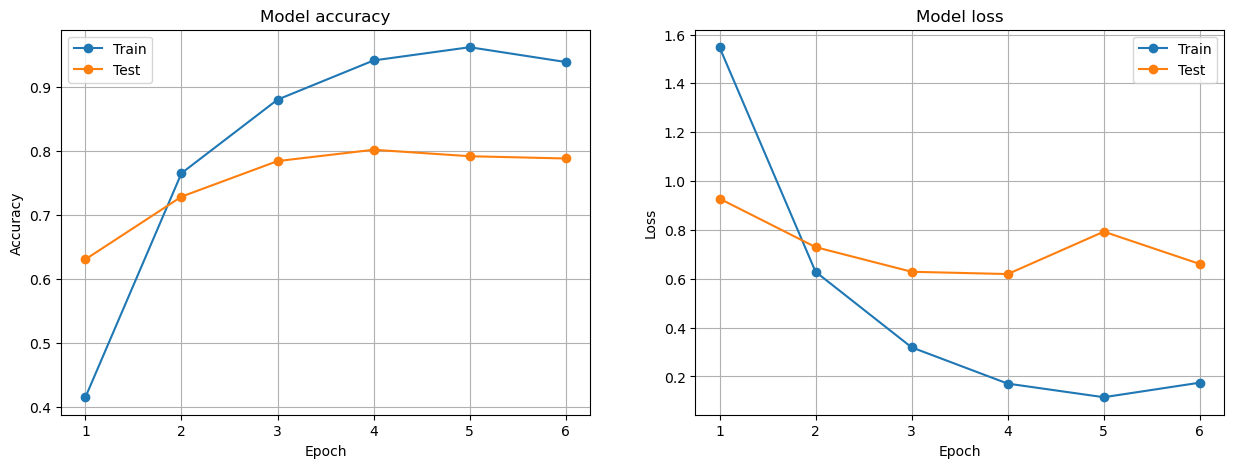

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks_list = [ 
    EarlyStopping(monitor='val_loss',    
                  patience=2,       
                  restore_best_weights=True,
                  verbose=1)
]

# in case we execute a training several times, we re-build the network 
# to its initial state if we want to compare the workouts...

# define the key to reload the initial state & structure of the network:
key = 'CWRU_temporal_init'
# define the path to be used:
model_path = os.path.join('models', key)
# load the network structure & initial weights:
model = tf.keras.models.load_model(model_path)

# Deterministic tensorflow training: 
# see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html
tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism() 

# train the DNN:
hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test), 
                 epochs=50, 
                 batch_size=64,                     # number of samples in the batch
                 callbacks = callbacks_list)

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

Now we compute the trained network predictions for the test datatset:

In [23]:
results = model.predict(x_test)          # restults is an array of probabilities vectors
inferences = results.argmax(axis=-1)     # extract the highest probablities

62/62 [==============================] - 1s 22ms/step


And we can plot the **confusion matrix** to  see if the networkd is well trained or not:

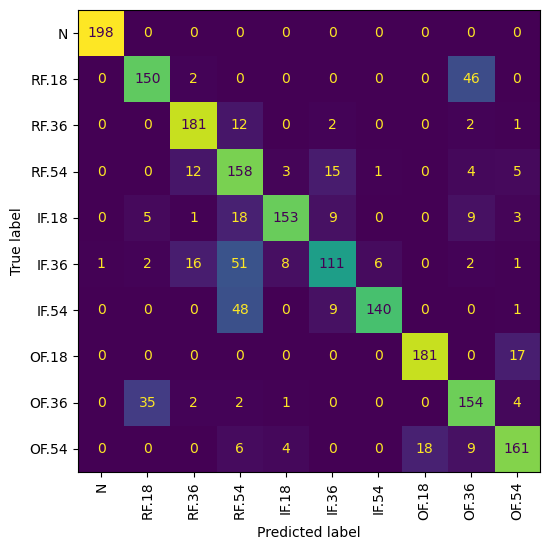

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig = plt.figure(figsize=(6,6))
axis = plt.axes()
ConfusionMatrixDisplay.from_predictions(lab_test, inferences, 
                                        ax=axis,
                                        display_labels=health_cond, 
                                        xticks_rotation='vertical',
                                        colorbar=False);

Not all the bearing defaults are classified with a good score...<br>
$\leadsto$ the next step is to try to train the network with the spectral datasets computed from the temporal samples to see if it's better ?

# 5 $-$ Finally the problem of the mini project: Train the neural network with the spectrum data set

## 5.1 $-$ Compute the spectral datasets

See **3.1 − Compute the spectral datasets** in the notebook *2-process_CWRU_data.ipynb* to help you to do the work....

In [25]:
H, S, N = A.shape
print(f"array A has <{S}> samples of <{N}> data point for each of the <{H}> health conditions ")

array A has <200> samples of <1900> data point for each of the <10> health conditions 


The spectra are computed with [numpy.fft.rfft](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html)<br>
On the web page, you can see how to compute the size of the spectrum:

In [26]:
if S % 2 == 0:
    N_spectrum = int(N/2+1)
else:
    N_spectrum = int((N+1)/2)
print(f"size of spectra: {N_spectrum}")    

size of spectra: 951


Now you must define and dimension 3 ndarrays of `floats` to store the spectra of the 3 temporal data arrays.<br>
For the dimensions, you must use `H`, `S` and `N_spectrum`:

In [27]:
A_spectrum = np.ndarray((H, S, N_spectrum), dtype=float)
B_spectrum = np.ndarray((H, S, N_spectrum), dtype=float)
C_spectrum = np.ndarray((H, S, N_spectrum), dtype=float)

Now you can compute the spectra with the `np.fft.rfft` function and fill in the 3 arrays (:

In [28]:
from numpy.fft import rfft
for spectrum_array, temporal_array in zip((A_spectrum, B_spectrum, C_spectrum), (A, B, C)):
    for h in range(H):
        for s in  range(S):
            sample_spectrun = np.abs(rfft(temporal_array[h, s]))   # we take the module of the Fourier spectrum
            spectrum_array[h, s] = sample_spectrun/sample_spectrun.max()  # normalize the spectum values in [0,1]

## 5.2 $-$ Prepare the data set for supervised learning

As we saw previously, we can keep only the first 400 spectral points in each sample, so you must define `x_full` and `y_full` with the appropriate dimensions:

In [29]:
N_spectrum = 400

x_full = np.ndarray((L*H*S, N_spectrum), dtype='float')
y_full = np.ndarray((L*H*S,), dtype='uint8')

Check:

In [30]:
x_full.shape, y_full.shape

((6000, 400), (6000,))

Then you can fill `x_full` and `y_full` appropriately (see **4.2 −
Prepare the labeled data for the training** to get some help):

In [31]:
i = 0
for spectrum in (A_spectrum, B_spectrum, C_spectrum):
    for h in range(H):
        for s in range(S):
            x_full[i] = spectrum[h, s, :N_spectrum]
            y_full[i] = h
            i += 1       

Let's have a quick look on the spectrum of rank 10:

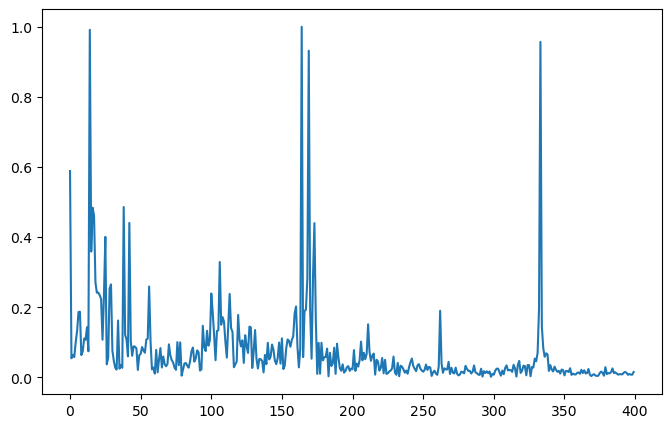

In [32]:
plt.figure(figsize=(8,5))
plt.plot(x_full[10]);

## 5.3 Split the full dataset into train and test datasets

see **4.3 Split the full dataset into train and test datasets** to get some help:

In [33]:
from sklearn.model_selection import train_test_split

x_train, x_test, lab_train, lab_test = train_test_split(x_full, y_full, 
                                                        stratify=y_full, 
                                                        test_size=0.33,        
                                                        random_state=SEED, 
                                                        shuffle=True)         

## 5.4 Transform labels to *one-hot* format

see **4.4 Transform labels to one-hot format** to get some help:

In [34]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' des labels :
y_train = to_categorical(lab_train)
y_test  = to_categorical(lab_test)

Check:

In [35]:
x_train.shape, x_test.shape, lab_train.shape, lab_test.shape, y_train.shape, y_test.shape

((4020, 400), (1980, 400), (4020,), (1980,), (4020, 10), (1980, 10))

## 5.5 $-$ Build the Neural Network for the spectral dataset

In [36]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# set the seed of the random generators used by tensorflow:
SEED = 1234
tf.random.set_seed(SEED)

# the 5 lines to build the neural network:
modelS = Sequential()
modelS.add(Input(shape=(N_spectrum,), name='Input'))
modelS.add(Dense(N_spectrum, activation='relu', name='H1'))
modelS.add(Dense(600, activation='relu', name='H2'))
modelS.add(Dense(200, activation='relu', name='H3'))
modelS.add(Dense(100, activation='relu', name='H4'))
modelS.add(Dense(H, activation='softmax', name='Output'))
modelS.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

In [37]:
modelS.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 H1 (Dense)                  (None, 400)               160400    
                                                                 
 H2 (Dense)                  (None, 600)               240600    
                                                                 
 H3 (Dense)                  (None, 200)               120200    
                                                                 
 H4 (Dense)                  (None, 100)               20100     
                                                                 
 Output (Dense)              (None, 10)                1010      
                                                                 
Total params: 542,310
Trainable params: 542,310
Non-trainable params: 0
_________________________________________________________________


In [38]:
import os

# Check wether the 'model' directory exist (create it if needed):
if not os.path.exists("models"): os.mkdir("models")

# define a uniq key:
key = 'CWRU_spectral_init'

# define the path where to store the network data:
path = os.path.join('models', key)

# savue the structure and the weights of the current neural network:
modelS.save(path)

# display the tree beginning at f'./models/{key}':
tree = scan_dir(f"./models/{key}")
print(f'\nFiles written:\n{tree}') 

INFO:tensorflow:Assets written to: models/CWRU_spectral_init/assets


INFO:tensorflow:Assets written to: models/CWRU_spectral_init/assets



Files written:
./models/CWRU_spectral_init/keras_metadata.pb
./models/CWRU_spectral_init/saved_model.pb
./models/CWRU_spectral_init/variables/variables.index
./models/CWRU_spectral_init/variables/variables.data-00000-of-00001
./models/CWRU_spectral_init/assets/



Train the `modelS` network:

You can try the earlyStopping an `val_loss` with patience of 1,2,3... to get the best scores in the confusion matrix...

Epoch 1/50
63/63 [==============================] - 3s 37ms/step - loss: 0.6189 - accuracy: 0.8303 - val_loss: 0.0916 - val_accuracy: 0.9697
Epoch 2/50
63/63 [==============================] - 1s 19ms/step - loss: 0.0508 - accuracy: 0.9858 - val_loss: 0.0238 - val_accuracy: 0.9949
Epoch 3/50
63/63 [==============================] - 1s 19ms/step - loss: 0.0124 - accuracy: 0.9978 - val_loss: 0.0273 - val_accuracy: 0.9914
Epoch 4/50
63/63 [==============================] - 1s 11ms/step - loss: 0.0253 - accuracy: 0.9915 - val_loss: 0.0148 - val_accuracy: 0.9965
Epoch 5/50
63/63 [==============================] - 1s 13ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.0070 - val_accuracy: 0.9995
Epoch 6/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0094 - val_accuracy: 0.9965
Epoch 7/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 0.9970
Epoch 7: earl

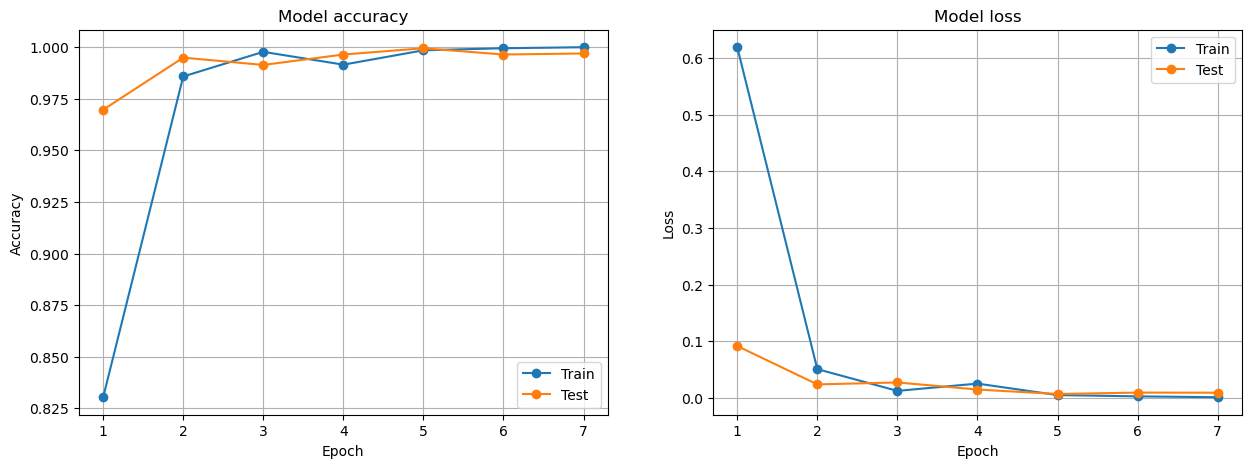

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks_list = [ 
    EarlyStopping(monitor='val_loss',    
                  patience=2,       
                  restore_best_weights=True,
                  verbose=1)
]

# in case we execute a training several times, we re-build the network 
# to its initial state if we want to compare the workouts...

# define the key to reload the initial state & structure of the network:
key = 'CWRU_spectral_init'
# define the path to be used:
model_path = os.path.join('models', key)
# load the network structure & initial weights:
modelS = tf.keras.models.load_model(model_path)

# Deterministic tensorflow training: 
# see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html
tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism() 

# train the DNN:
hist = modelS.fit(x_train, y_train,
                 validation_data=(x_test, y_test), 
                 epochs=50, 
                 batch_size=64,                     # number of samples in the batch
                 callbacks = callbacks_list)

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

Now we compute the trained network predictions for the test datatset:

In [40]:
results = modelS.predict(x_test)          # restults is an array of probabilities vectors
inferences = results.argmax(axis=-1)     # extract the highest probablities

62/62 [==============================] - 0s 6ms/step


And we can plot the **confusion matrix** to  see if the networkd is well trained or not:

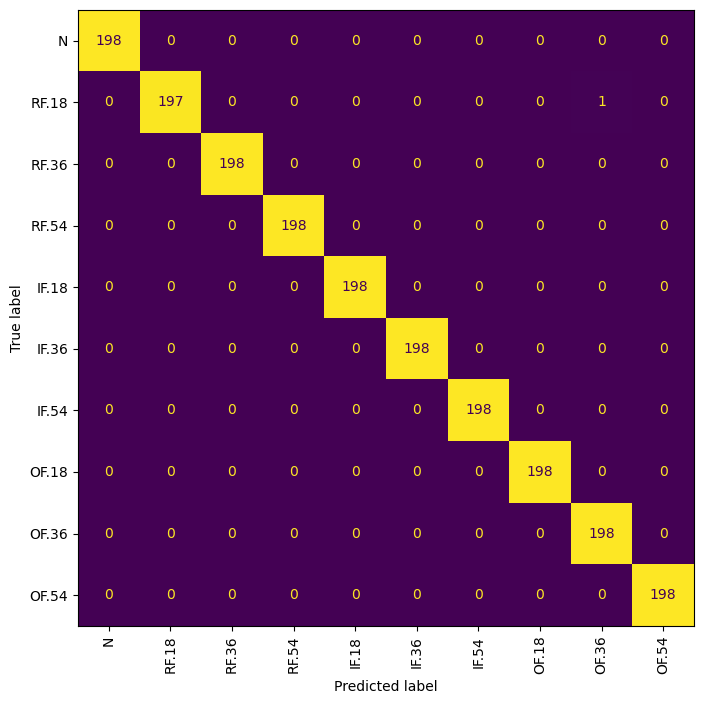

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig = plt.figure(figsize=(8,8))
axis = plt.axes()
ConfusionMatrixDisplay.from_predictions(lab_test, inferences, 
                                        ax=axis,
                                        display_labels=health_cond, 
                                        xticks_rotation='vertical',
                                        colorbar=False);